In [1]:
import math
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, GaussianBlur
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF

# MedMNIST import
import medmnist
from medmnist import INFO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- MedMNIST Data setup ---
data_flag = 'chestmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', download=True)
numSamples = len(train_dataset)
                      

Using device: cuda
Using downloaded and verified file: C:\Users\alexr\.medmnist\chestmnist.npz


In [2]:
# Prepare data tensors 
def _get_tensor(ds, n):
    """Stack first n samples, convert to float32 in [0,1]."""
    imgs = []
    for i in range(n):
        x, _ = ds[i]
        if isinstance(x, torch.Tensor):
            t = x.float() / 255.0
        elif isinstance(x, np.ndarray):
            t = torch.from_numpy(x).float() / 255.0
            if t.ndim == 3:
                t = t.permute(2, 0, 1)
        else:
            t = TF.to_tensor(x)
        imgs.append(t[0])
    return torch.stack(imgs).to(device)

# Load and prepare dataset
X_raw = _get_tensor(train_dataset, numSamples)  # (N, H, W)
dim = X_raw[0].numel()  # e.g. 28*28 = 784
r = 25  # bottleneck / testing rank

# X Stuff
X = X_raw.view(numSamples, -1).T  # (dim, numSamples)
gammaX = 1 / (numSamples) * X @ X.T + 1e-5 * torch.eye(dim, device=device)
L_X = torch.linalg.cholesky(gammaX)  # (dim, dim)
mu_X = X.mean(dim=1, keepdim=True)  
X_centered = X - mu_X  
covX = 1 / (numSamples - 1) * (X_centered @ X_centered.T) + 1e-5 * torch.eye(dim, device=device)
K_X = torch.linalg.cholesky(covX)

# Classic AE Theoretical Optimum
U, S, Vh = torch.linalg.svd(L_X) 
U_r, S_r, Vh_r = U[:, :r], torch.diag(S[:r]), Vh[:r, :]
L_X_r = U_r @ S_r @ Vh_r
M_r_c = L_X_r @ torch.linalg.pinv(L_X)

# Aff Lin Optimal Bias Vector
U, S, Vh = torch.linalg.svd(K_X) 
U_r, S_r, Vh_r = U[:, :r], torch.diag(S[:r]), Vh[:r, :]
K_X_r = U_r @ S_r @ Vh_r
M_r_al = K_X_r @ torch.linalg.pinv(K_X)
b_al = (torch.eye(dim, device=device) - M_r_al) @ mu_X

In [ ]:
# --- Autoencoder setup -------------------------------------------------------
batch_size = 128
num_epochs = 200

# Define Linear Autoencoder model
class ClassicLinearAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, bottleneck_dim, bias=False)
        self.decoder = nn.Linear(bottleneck_dim, input_dim, bias=False)

    def forward(self, x):
        return self.decoder(self.encoder(x))
    
# Define Affine Linear Autoencoder model
class AffLinAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, bottleneck_dim, bias=False)
        self.decoder = nn.Linear(bottleneck_dim, input_dim, bias=True)

    def forward(self, x):
        return self.decoder(self.encoder(x))

# Instantiate model, optimizer, and loss
modelClassic     = ClassicLinearAutoencoder(input_dim=dim, bottleneck_dim=r).to(device)
modelAffLin = AffLinAutoencoder(input_dim=dim, bottleneck_dim=r).to(device)
optimizerClassic = optim.Adam(modelClassic.parameters(), lr=1e-3)
optimizerAffLin = optim.Adam(modelAffLin.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Prepare training data tensors
X_tensor = X.T 
Y_tensor = X.T  

# Classic AE Training
train_errors_classic = []
for epoch in range(1, num_epochs + 1):
    modelClassic.train()
    optimizerClassic.zero_grad()

    outputs = modelClassic(Y_tensor)
    target  = X_tensor

    loss = criterion(outputs, target)
    loss.backward()
    optimizerClassic.step()

    # Evaluate and store error after each epoch
    with torch.no_grad():
        A_learned = modelClassic.decoder.weight @ modelClassic.encoder.weight

        diffs = A_learned @ X - X
        avg_l2_err = torch.norm(diffs, dim=0).mean().item()
        train_errors_classic.append(avg_l2_err)
        
# Affine Linear AE Training
train_errors_afflin = []
for epoch in range(1, num_epochs + 1):
    modelAffLin.train()
    optimizerAffLin.zero_grad()

    outputs = modelAffLin(Y_tensor)
    target  = X_tensor

    loss = criterion(outputs, target)
    loss.backward()
    optimizerAffLin.step()

    # Evaluate and store error after each epoch
    with torch.no_grad():
        A_learned = modelAffLin.decoder.weight @ modelAffLin.encoder.weight
        b_learned = modelAffLin.decoder.bias.view(-1, 1)  

        diffs = A_learned @ X + b_learned - X
        avg_l2_err = torch.norm(diffs, dim=0).mean().item()  # average per-sample l2 discrepancy

        train_errors_afflin.append(avg_l2_err)

C:\Users\alexr\AppData\Local\Temp\ipykernel_32708\1501529531.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


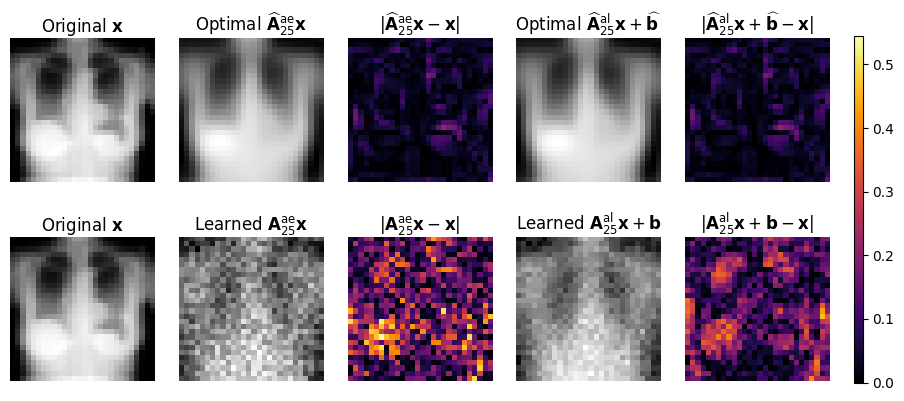

In [5]:
 #--- Plotting---
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Example sample index for plotting
idx = 7181

# Prepare images for plotting
x_img = X_raw[idx].view(28, 28).cpu()
opt_img_c   = (M_r_c @ X)[:, idx].view(28, 28).cpu()
learn_img_c = (A_learned @ X)[:, idx].view(28, 28).cpu()
opt_img_al   = (M_r_al @ X + b_al)[:, idx].view(28, 28).cpu()
learn_img_al = (A_learned @ X + b_learned)[:, idx].view(28, 28).detach().cpu()

# Errors
err_opt_c   = torch.abs(opt_img_c - x_img)
err_learn_c = torch.abs(learn_img_c - x_img)
err_opt_al   = torch.abs(opt_img_al - x_img)
err_learn_al = torch.abs(learn_img_al - x_img)

err_vmin, err_vmax = 0.0, max(
    err_opt_c.max(), err_learn_c.max(),
    err_opt_al.max(), err_learn_al.max()
).item()

# Create 2×3 plot grid (Original | Reconstruction | Errors)
fig = plt.figure(figsize=(11, 4.5))
gs  = gridspec.GridSpec(
    2, 6,
    width_ratios=[1, 1, 1, 1, 1, 0.06],
    wspace=0.20, hspace=0.35
)

# row 0, col 0: Original image
ax = fig.add_subplot(gs[0, 0])
ax.imshow(x_img, cmap='gray')
ax.set_title(r'Original $\mathbf{x}$', pad=4)
ax.axis('off')

# row 0, col 1: Optimal reconstruction classic ae
ax = fig.add_subplot(gs[0, 1])
ax.imshow(opt_img_c, cmap='gray')
ax.set_title(fr'Optimal $\widehat{{\mathbf{{A}}}}_{{{r}}}^{{\text{{ae}}}} \mathbf{{x}}$', pad=4)
ax.axis('off')

# row 0, col 2: Optimal absolute error classic ae
ax = fig.add_subplot(gs[0, 2])
im = ax.imshow(err_opt_c, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\widehat{{\mathbf{{A}}}}_{{{r}}}^{{\text{{ae}}}} \mathbf{{x}} - \mathbf{{x}}|$', pad=4)
ax.axis('off')

# row 0, col 3: Optimal aff lin
ax = fig.add_subplot(gs[0, 3])
ax.imshow(opt_img_al, cmap='gray')
ax.set_title(fr'Optimal $\widehat{{\mathbf{{A}}}}_{{{r}}}^{{\text{{al}}}} \mathbf{{x}} + \widehat{{\mathbf{{b}}}}$', pad=4)
ax.axis('off')

# row 0, col 4:  Optimal absolute error aff lin
ax = fig.add_subplot(gs[0, 4])
ax.imshow(err_opt_al, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\widehat{{\mathbf{{A}}}}_{{{r}}}^{{\text{{al}}}} \mathbf{{x}} + \widehat{{\mathbf{{b}}}} - \mathbf{{x}}|$', pad=4)
ax.axis('off')

# --- ROW 1 ---

# row 1, col 0: Original image
ax = fig.add_subplot(gs[1, 0])
ax.imshow(x_img, cmap='gray')
ax.set_title(r'Original $\mathbf{x}$', pad=4)
ax.axis('off')

# row 1, col 1: Learned reconstruction classic ae
ax = fig.add_subplot(gs[1, 1])
ax.imshow(learn_img_c, cmap='gray')
ax.set_title(fr'Learned $\mathbf{{A}}_{{{r}}}^{{\text{{ae}}}} \mathbf{{x}}$', pad=4)
ax.axis('off')

# row 0, col 2: Learned absolute error classic ae
ax = fig.add_subplot(gs[1, 2])
im = ax.imshow(err_learn_c, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\mathbf{{A}}_{{{r}}}^{{\text{{ae}}}} \mathbf{{x}} - \mathbf{{x}}|$', pad=4)
ax.axis('off')

# row 0, col 3: Learned aff lin
ax = fig.add_subplot(gs[1, 3])
ax.imshow(learn_img_al, cmap='gray')
ax.set_title(fr'Learned $\mathbf{{A}}_{{{r}}}^{{\text{{al}}}} \mathbf{{x}} + \mathbf{{b}}$', pad=4)
ax.axis('off')

# row 0, col 4:  Learned absolute error aff lin
ax = fig.add_subplot(gs[1, 4])
ax.imshow(err_learn_al, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\mathbf{{A}}_{{{r}}}^{{\text{{al}}}} \mathbf{{x}} + \mathbf{{b}} - \mathbf{{x}}|$', pad=4)
ax.axis('off')

# color bar
cax = fig.add_subplot(gs[:, 5])
plt.colorbar(im, cax=cax)
cax.yaxis.tick_right()

plt.tight_layout()
plt.show()

#out_dir = f"Classic/MedMNIST/Pics"
#os.makedirs(out_dir, exist_ok=True)
#plt.savefig(f"{out_dir}/classic_{data_flag}_mapping{idx}_errorcomparison.png", dpi=300)